In [1]:
!pip install --pre deepchem

In [2]:
import deepchem as dc
dc.__version__

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

In [3]:
!pip install pubchempy

In [4]:
import os
import pandas as pd
from pubchempy import get_cids,get_compounds

In [5]:
#The screenshot they have in the tutorial can't be reaccessed from my colab.

In [6]:
current_dir = os.path.dirname(os.path.realpath('__file__'))

dc.utils.download_url(
  'https://github.com/deepchem/deepchem/raw/master/datasets/Positive%20Modulators%20Summary_%20918.TUC%20_%20v1.xlsx',
  current_dir,
  'Positive Modulators Summary_918.TUC_v1.xlsx'
)

In [9]:
raw_data_file = os.path.join(current_dir, 'Positive Modulators Summary_918.TUC_v1.xlsx')
raw_data_excel = pd.ExcelFile(raw_data_file)

raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

In [10]:
raw_data.loc[raw_data.index[:5]]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Metric #1 (-120 mV Peak),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,Vehicle,NaN,4,Replications,NaN
1,TA ##,Position,TA ID,Mean,SD,Threshold (%) = Mean + 4xSD,N #1 (%),N #2 (%)
2,1,1-A02,Penicillin V Potassium,-12.868936,6.747049,14.119261,-10.40397,-18.192942
3,2,1-A03,Mycophenolate Mofetil,-12.868936,6.747049,14.119261,-12.445268,-11.717468
4,3,1-A04,Metaxalone,-12.868936,6.747049,14.119261,-8.655724,-17.775287


In [11]:
#the column headers are in row 1 for some reason.

raw_data = raw_data.iloc[2:, [2,6,7]]

raw_data.reset_index(inplace=True)

raw_data.columns = ['label', 'drug', 'n1', 'n2']

In [12]:
raw_data.loc[raw_data.index[:5]]

,label,drug,n1,n2
0,2,Penicillin V Potassium,-10.40397,-18.192942
1,3,Mycophenolate Mofetil,-12.445268,-11.717468
2,4,Metaxalone,-8.655724,-17.775287
3,5,Terazosin·HCl,-11.504804,16.082458
4,6,Fluvastatin·Na,-11.135366,-14.553018


In [13]:
drugs = raw_data['drug'].values #English Nams
drugs[0]

'Penicillin V Potassium'

In [14]:
get_compounds(drugs[1], 'name')
#pubchempy has a method called 'get_compounds' that searches the pubchem database for the information associated with a given compound (identified by name)
#this saves us the need to save the SMILES strings & other publicly available data when running an experiment and recording data

[Compound(5281078)]

In [15]:
#getting the SMILES string for Penicillin V Potassium
get_compounds(drugs[1], 'name')[0].canonical_smiles

'CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O'

In [16]:
import re

ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H20': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H20', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)

    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0]
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

In [ ]:
smiles_map = {}
for i, compound in enumerate(drugs):
    try:
        smiles_map[compound] = compound_to_smiles(compound)
        print('.', end="")
    except:
        print("Errored on %s" % i)
        continue

.....................................Errored on 37
...................................Errored on 73
..........................Errored on 100
........Errored on 109
..................................Errored on 144
.........Errored on 154
....Errored on 159
..Errored on 162
.Errored on 164
............Errored on 177
.................Errored on 195
...............................................Errored on 243
Errored on 244
...

In [18]:
smiles_data = raw_data
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x] if x in smiles_map else None)

In [19]:
smiles_data.loc[smiles_data.index[:500]]

,label,drug,n1,n2
0,2,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.40397,-18.192942
1,3,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C...,-12.445268,-11.717468
2,4,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.655724,-17.775287
3,5,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.504804,16.082458
4,6,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.135366,-14.553018
...,...,...,...,...
425,427,CC1=C(C=C(C=C1)C(=O)NC2=CC(=CC(=C2)C(F)(F)F)N3...,-10.912415,-10.926486
426,428,C1=CN(C(=O)N=C1N)CC(CO)OCP(=O)(O)O,4.942839,2.863256
427,429,CCOC(=O)CC(C(=O)OCC)SP(=S)(OC)OC,-0.00975,-5.685437
428,430,C1CC1N2C=C(C(=O)C3=CC(=C(C=C32)N4CCNCC4)F)C(=O)O,-7.269367,-7.632633


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

In [47]:
smiles_data.head(10)

,label,drug,n1,n2,len
0,2,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.40397,-18.192942,56
1,3,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C...,-12.445268,-11.717468,53
2,4,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.655724,-17.775287,30
3,5,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.504804,16.082458,57
4,6,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.135366,-14.553018,66
5,7,CC(=O)OC1=CC=CC=C1C(=O)NC2=NC=C(S2)[N+](=O)[O-],-10.701136,-14.939332,47
6,8,C1CCC(CC1)NC(=O)N(CCCl)N=O,-10.751916,-12.858454,26
7,9,CCC(C)C1C(CCC2(O1)CC3CC(O2)CC=C(C(C(C=CC=C4COC...,-9.590272,-9.546986,115
8,10,CN(C)C1C2CC3C(C4=C(C=CC(=C4C(=C3C(=O)C2(C(=C(C...,1.301883,-9.665487,72
9,11,CCC(CO)NCCNC(CC)CO.Cl.Cl,-14.358959,14.627994,24


Text(0.5, 1.0, 'Distribution of len(smiles)')

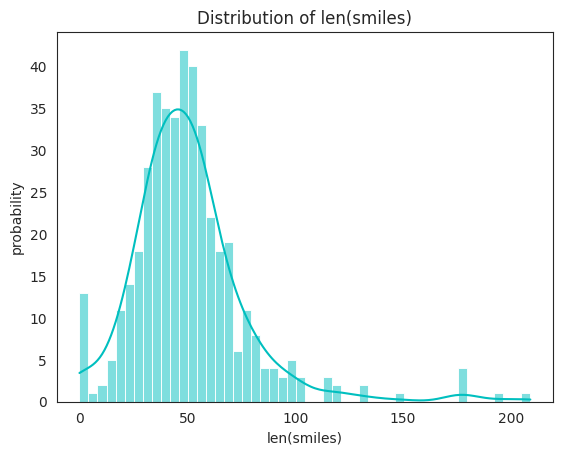

In [43]:
smiles_data['len'] = [len(i) if i is not None else 0 for i in smiles_data['drug']]
smiles_lens = [len(i) if i is not None else 0 for i in smiles_data['drug']]
sns.histplot(smiles_lens, kde=True, bins=50, color="c")

plt.xlabel('len(smiles)')
plt.ylabel('probability')
plt.title("Distribution of len(smiles)")

In [49]:
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]
print(type(suspiciously_large))
#smiles_data.index[suspiciously_large] -> the indexes of the suspiciously large lens in the original smiles_data
#accessing the ['drug'] labels of said smiles_data.loc
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

<class 'numpy.ndarray'>


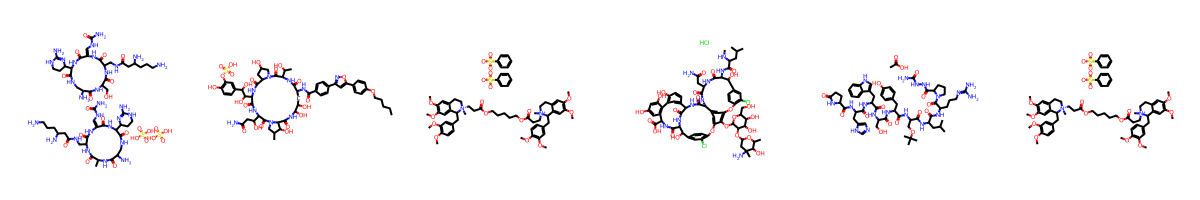

In [51]:
#Drawing the molecules
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)
#lesson: remove molecules that don't fit the use case

In [52]:
#drop large molecules
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

In [53]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

,n1,n2
37,-10.842444,-18.32288
62,NaN,-7.826604
73,-11.106872,-8.917368
100,-13.659317,-11.611764
109,-7.81067,-18.182148
144,-7.095241,-11.162824
154,-11.505111,-12.641489
159,-9.27275,-12.801458
162,-12.845569,-11.462743
164,4.947861,-16.225784


In [55]:
df = smiles_data.dropna(axis=0, how='any') #if any NaN are present, drop that label

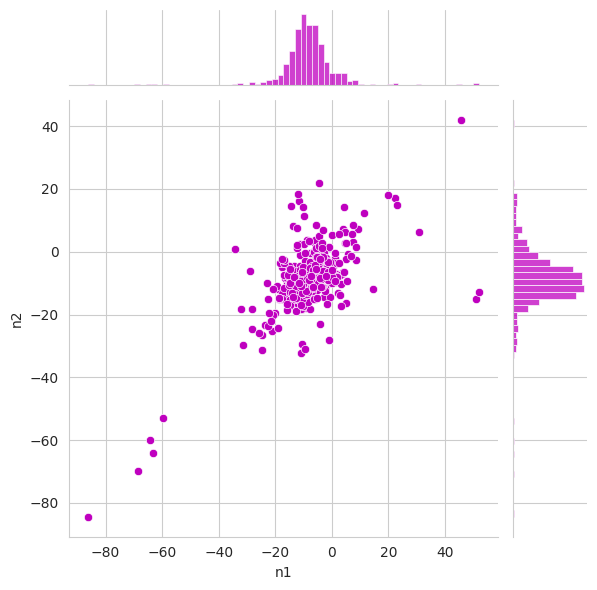

In [66]:
sns.jointplot(x='n1', y='n2', data=smiles_data, color="m")

Text(0, 0.5, 'probability')

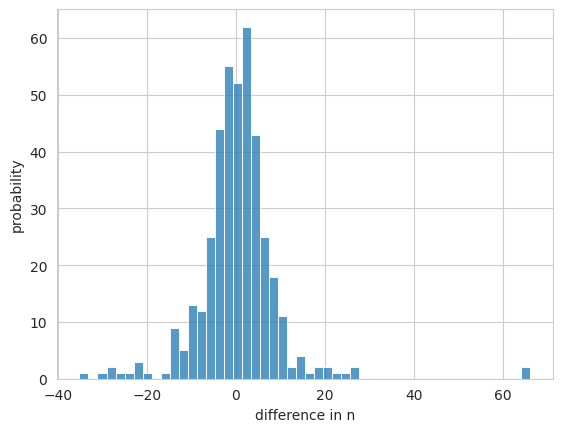

In [68]:
diff_df = df['n1'] - df['n2']

sns.histplot(diff_df)
plt.xlabel('difference in n') #comparing the 2 different trials of the same drug
plt.ylabel('probability')

In [73]:
from scipy import stats
mean, std = stats.norm.fit(np.asarray(diff_df, dtype=np.float32))

print("The 68 percent confidence interval is {}".format(std))
print("The 95 percent confidence interval is {}".format(std*2))
print("The 98 percent confidence interval is {}".format(std*3))

ci_95 = std*2

The 68 percent confidence interval is 8.925040245056152
The 95 percent confidence interval is 17.850080490112305
The 98 percent confidence interval is 26.775120735168457


In [74]:
noisy = diff_df[abs(diff_df) > ci_95]

In [76]:
df = df.drop(noisy.index) #dropping everytihng outside our 95% confidence interval
#95% confidence = 95% of the time our values will fall within this range

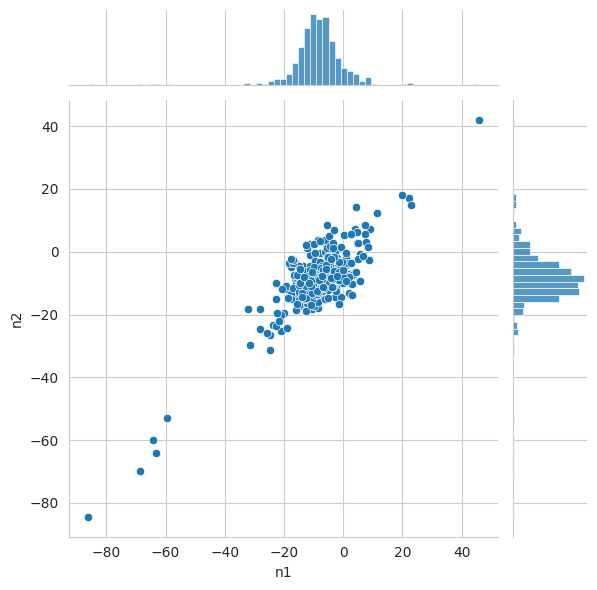

In [77]:
sns.jointplot(x='n1', y='n2', data=df)

In [79]:
avg_df = df[['label', 'drug']].copy()
n_avg = df[['n1', 'n2']].mean(axis=1)
avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)

Text(0, 0.5, 'activity')

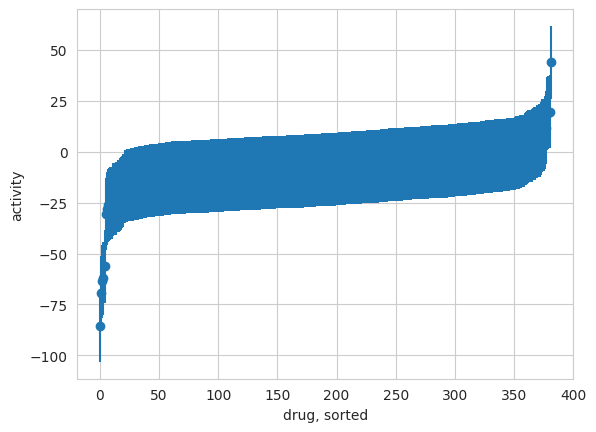

In [80]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')
plt.xlabel('drug, sorted')
plt.ylabel('activity')

In [81]:
#Now, what sort of model should we use for our (a) problem and (b) data?

In [82]:
#we can't transfer learning over because we don't have another dataset of similar characteristics

In [83]:
avg_df.loc[:, 'active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

In [84]:
avg_df.to_csv('modulators.csv', index=False)

In [85]:
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='drug', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

In [86]:
#it's sometimes necessary / useful to transform the data. DeepChem comes packaged with many useful transformers.

In [91]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
#We're using a BalancingTransformer here since the number of actives is very low + this is a classification model.
#What other types of transformers are there?
dataset = transformer.transform(dataset)

In [92]:
dc.utils.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')